In [ ]:
# cv_analysis.ipynb

import json
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader


PROJECT_ROOT = Path("..").resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data.dataloader import (
    ForgeryDataset,
    detection_collate_fn,
    get_val_transform,
)
from src.models.mask2former_v2 import Mask2FormerForgeryModel
from src.utils.config_utils import load_yaml, sanitize_model_kwargs


In [2]:
# -----------------
# Constants / Paths
# -----------------

OOF_ROOT = PROJECT_ROOT / "experiments" / "oof_results"
FULL_TRAIN_ROOT = PROJECT_ROOT / "experiments" / "full_train_results"

CLS_THRESHOLD_PATH = (
    PROJECT_ROOT / "experiments" / "cls_threshold_sweep" / "cls_threshold_sweep.csv"
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CFG_PATH = PROJECT_ROOT / "config" / "base.yaml"

In [3]:
# -----------------
# Load cls_threshold
# -----------------
cls_threshold = pd.read_csv(CLS_THRESHOLD_PATH)

# Quick sanity check
display(cls_threshold.head())
print(f"Loaded {len(cls_threshold)} rows")
print(cls_threshold.columns.tolist())

,gate,cls_threshold,mask_threshold,idx_in_batch,gate_pass,num_keep,max_cls_prob,max_mask_prob,any_fg_pre_keep,any_fg_post_keep,image_forged_prob
0,-1.0,0.05,0.5,0,1,15,0.130176,1.000000,1,1,0.613294
1,-1.0,0.05,0.5,1,1,15,0.201880,0.999997,1,1,0.474688
2,-1.0,0.05,0.5,2,1,0,0.029606,0.998738,1,0,0.186493
3,-1.0,0.05,0.5,3,1,0,0.020249,0.999816,1,0,0.017884
4,-1.0,0.05,0.5,0,1,15,0.162346,0.632276,1,1,0.607723


Loaded 51760 rows
['gate', 'cls_threshold', 'mask_threshold', 'idx_in_batch', 'gate_pass', 'num_keep', 'max_cls_prob', 'max_mask_prob', 'any_fg_pre_keep', 'any_fg_post_keep', 'image_forged_prob']


In [11]:
EXPERIMENTS = PROJECT_ROOT / "experiments"
# Default sweep output dir used by the script
DEFAULT_SWEEP_DIR = EXPERIMENTS / "full_model_full_data_baseline"

# Find any sweep dirs that contain a summary.json (supports multiple runs / renamed dirs)
summary_paths = sorted(EXPERIMENTS.glob("**/summary.json"))

if not summary_paths:
    raise FileNotFoundError(f"No summary.json found under {EXPERIMENTS}")

rows = []
for sp in summary_paths:
    try:
        data = json.loads(sp.read_text())
    except Exception:
        continue
    if not isinstance(data, list) or (len(data) and not isinstance(data[0], dict)):
        continue
    df = pd.DataFrame(data)
    # Only keep summaries that look like our sweep outputs
    needed = {"cls_threshold", "area_threshold", "topk", "mask_threshold", "score"}
    if not needed.issubset(df.columns):
        continue
    df["sweep_dir"] = str(sp.parent.relative_to(PROJECT_ROOT))
    df["summary_path"] = str(sp.relative_to(PROJECT_ROOT))
    rows.append(df)

if not rows:
    raise FileNotFoundError("Found summary.json files, but none matched expected sweep schema.")

sweeps = pd.concat(rows, ignore_index=True)

# Basic cleanup / types
for c in ["cls_threshold", "area_threshold", "mask_threshold", "score"]:
    sweeps[c] = pd.to_numeric(sweeps[c], errors="coerce")
sweeps["topk"] = pd.to_numeric(sweeps["topk"], errors="coerce").astype("Int64")

display(sweeps.head(10))
print("Total sweep rows:", len(sweeps))
print("Sweep dirs:", sweeps["sweep_dir"].nunique())

# --- Best configs overall + per sweep dir (concise) ---

TOPN = 20

best_overall = sweeps.sort_values("score", ascending=False).head(TOPN)
display(best_overall[[
    "score", "cls_threshold", "area_threshold", "topk", "mask_threshold", "sweep_dir", "csv"
]].reset_index(drop=True))

best_per_dir = (
    sweeps.sort_values("score", ascending=False)
          .groupby("sweep_dir", as_index=False)
          .head(1)
          .sort_values("score", ascending=False)
)
display(best_per_dir[[
    "score", "cls_threshold", "area_threshold", "topk", "mask_threshold", "sweep_dir", "csv"
]].reset_index(drop=True))

# --- Quick pivots (helpful to see sensitivity) ---
# Pick a single sweep dir to inspect (best-scoring one by default)

focus_dir = best_per_dir.iloc[0]["sweep_dir"]
focus = sweeps[sweeps["sweep_dir"] == focus_dir].copy()

print("Focus sweep_dir:", focus_dir)
print("Rows:", len(focus))

# For each topk, show best score per (cls_threshold, area_threshold)
for k in sorted(focus["topk"].dropna().unique()):
    sub = focus[focus["topk"] == k]
    pivot = sub.pivot_table(
        index="cls_threshold",
        columns="area_threshold",
        values="score",
        aggfunc="max",
    ).sort_index().sort_index(axis=1)
    print(f"\n=== topk = {int(k)} (max score per cell) ===")
    display(pivot)

# --- Optional: list the top CSVs to inspect / submit ---
# (Paths were written by the sweep script.)

top_csvs = sweeps.sort_values("score", ascending=False).head(10)[["score", "csv", "sweep_dir"]]
display(top_csvs.reset_index(drop=True))

FileNotFoundError: Found summary.json files, but none matched expected sweep schema.

In [4]:
cls_threshold['cls_threshold'].value_counts()

cls_threshold
0.05    5176
0.10    5176
0.20    5176
0.30    5176
0.40    5176
0.50    5176
0.60    5176
0.70    5176
0.80    5176
0.90    5176
Name: count, dtype: int64

In [5]:
# aggregate per cls_threshold across all images
summary = (
    cls_threshold.groupby("cls_threshold")
      .agg(
          gate_pass_rate=("gate_pass", "mean"),
          avg_num_keep=("num_keep", "mean"),
          any_fg_pre_rate=("any_fg_pre_keep", "mean"),
          any_fg_post_rate=("any_fg_post_keep", "mean"),
          avg_max_cls_prob=("max_cls_prob", "mean"),
          avg_max_mask_prob=("max_mask_prob", "mean"),
          avg_image_forged_prob=("image_forged_prob", "mean"),
      )
      .reset_index()
      .sort_values("cls_threshold")
)

display(summary)

,cls_threshold,gate_pass_rate,avg_num_keep,any_fg_pre_rate,any_fg_post_rate,avg_max_cls_prob,avg_max_mask_prob,avg_image_forged_prob
0,0.05,1.0,10.989181,0.96194,0.729328,0.135911,0.95336,0.527448
1,0.10,1.0,9.518740,0.96194,0.641422,0.135911,0.95336,0.527448
2,0.20,1.0,0.935085,0.96194,0.232419,0.135911,0.95336,0.527448
3,0.30,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
4,0.40,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
5,0.50,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
6,0.60,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
7,0.70,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
8,0.80,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
9,0.90,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448


cls weight sweep

Found runs: 7
full_full_cls_w0.0 w_mask_cls= 1.0
full_full_cls_w0.1 w_mask_cls= 1.0
full_full_cls_w0.25 w_mask_cls= 1.0
full_full_cls_w0.25_groupfold w_mask_cls= 1.0
full_full_cls_w0.5 w_mask_cls= 1.0
full_full_cls_w1.0 w_mask_cls= 1.0
full_full_cls_w2.0 w_mask_cls= 1.0


,run_name,run_dir,w_mask_cls,epochs_logged,steps_logged,cls_max_mean_last,cls_max_p95_last,mask_max_mean_last,img_forged_mean_last,loss_total_last,loss_mask_cls_last,loss_auth_penalty_last
0,full_full_cls_w0.0,..\experiments\cls_collapse\full_full_cls_w0.0,1.0,5,6470,0.118643,0.141841,0.926518,0.683643,1.375971,0.328732,2.192139e-14
1,full_full_cls_w0.1,..\experiments\cls_collapse\full_full_cls_w0.1,1.0,5,6470,0.099067,0.099142,0.999999,0.528509,1.391968,0.360660,3.738233e-13
2,full_full_cls_w0.25,..\experiments\cls_collapse\full_full_cls_w0.25,1.0,25,32350,0.152679,0.163434,0.999965,0.506893,1.968135,0.201979,1.151884e-12
3,full_full_cls_w0.25_groupfold,..\experiments\cls_collapse\full_full_cls_w0.2...,1.0,25,32350,0.146112,0.146112,0.999999,0.417405,1.384327,0.181029,5.308896e-13
4,full_full_cls_w0.5,..\experiments\cls_collapse\full_full_cls_w0.5,1.0,5,6470,0.112971,0.112973,1.000000,0.557180,1.393934,0.334875,1.091131e-12
5,full_full_cls_w1.0,..\experiments\cls_collapse\full_full_cls_w1.0,1.0,5,6470,0.111575,0.111709,0.999980,0.541513,1.326385,0.350410,2.345868e-13
6,full_full_cls_w2.0,..\experiments\cls_collapse\full_full_cls_w2.0,1.0,5,6470,0.113916,0.113918,0.999225,0.725120,1.309339,0.366402,1.386722e-12


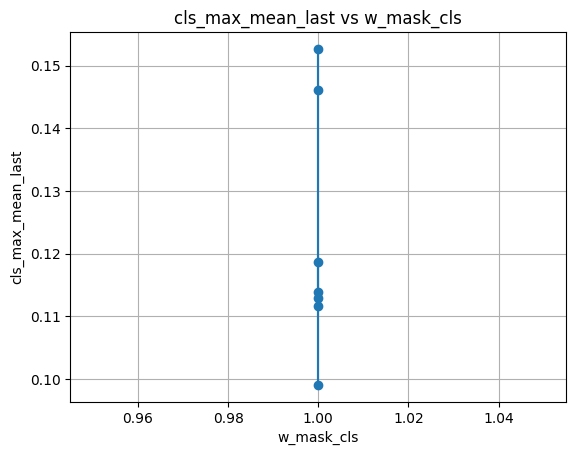

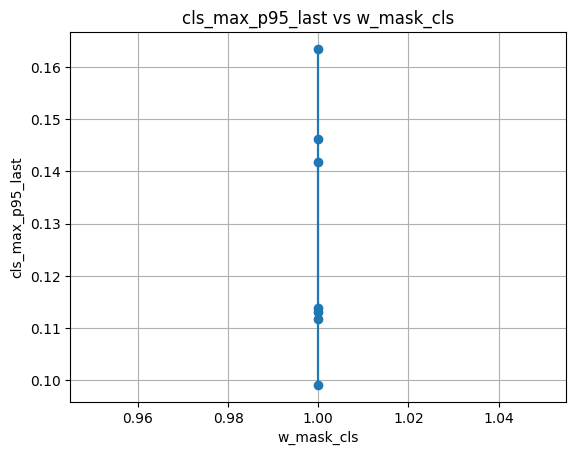

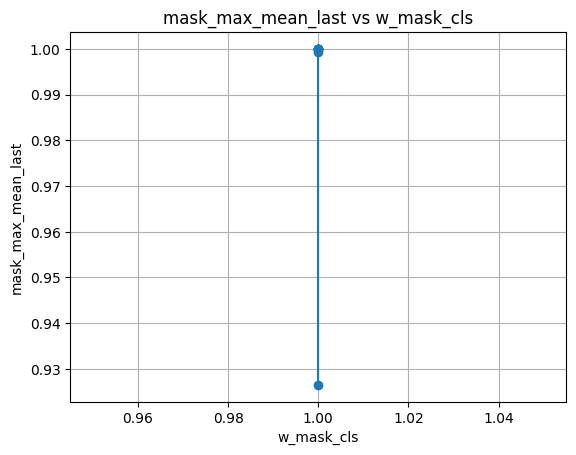

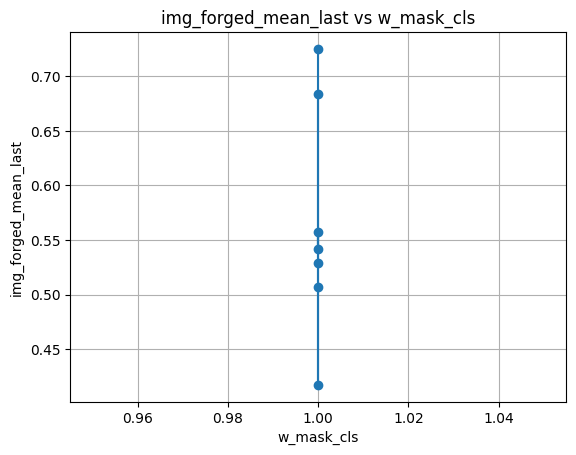

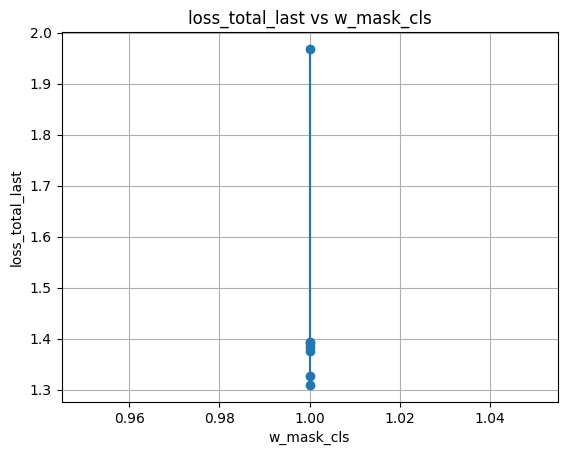

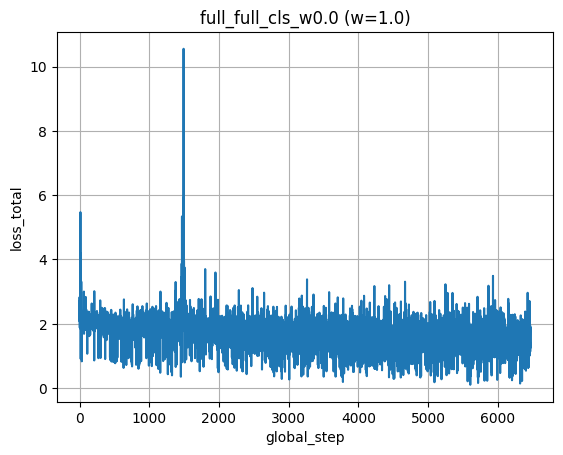

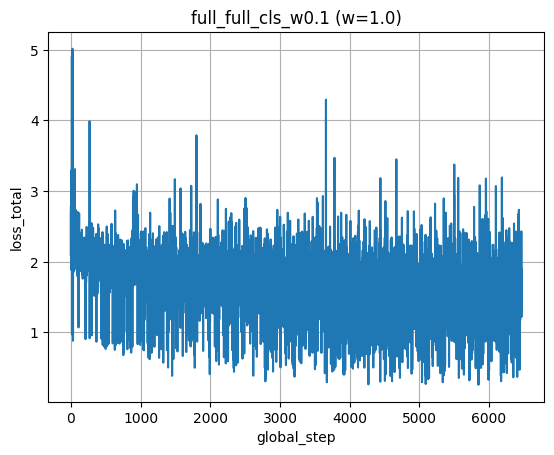

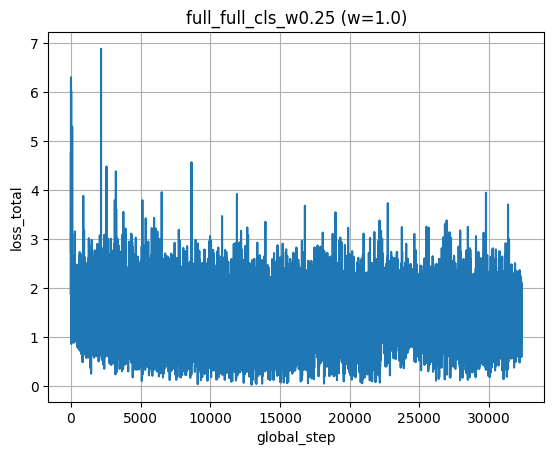

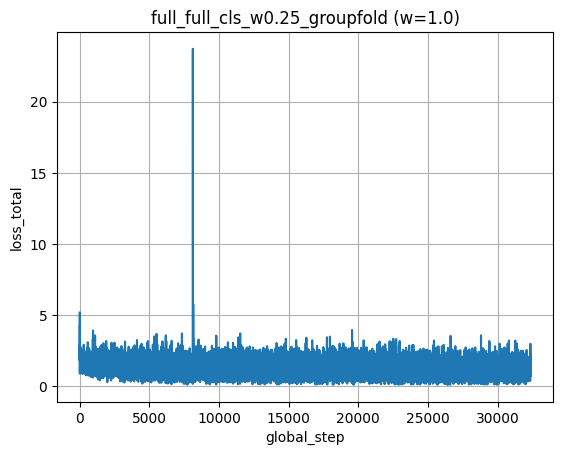

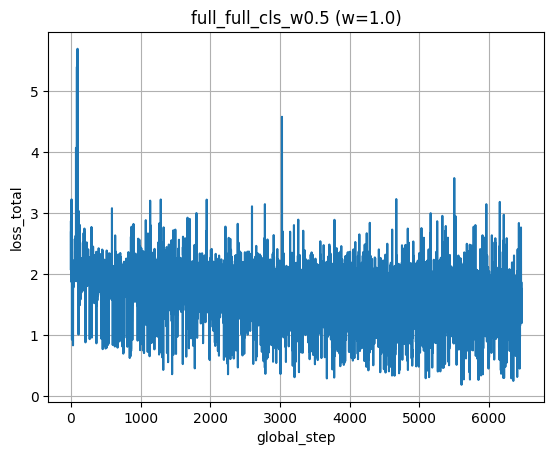

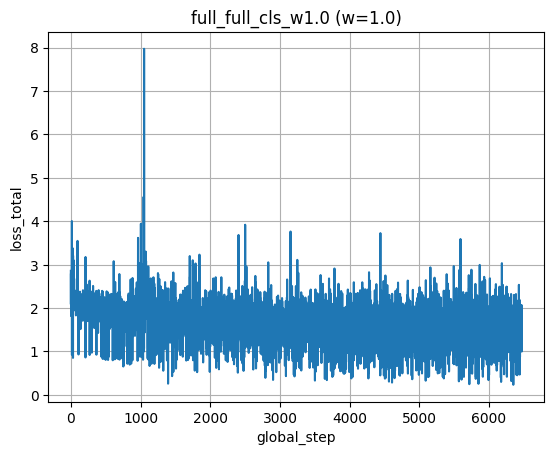

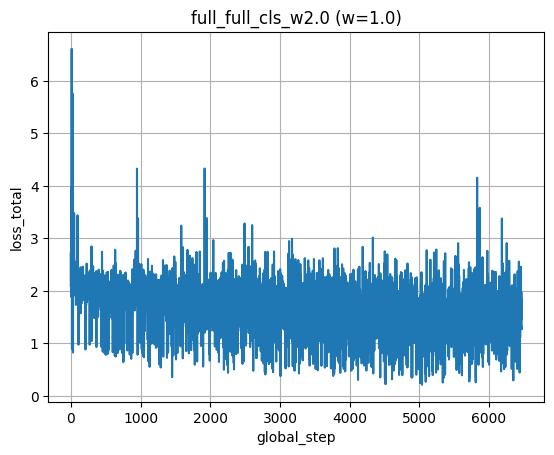

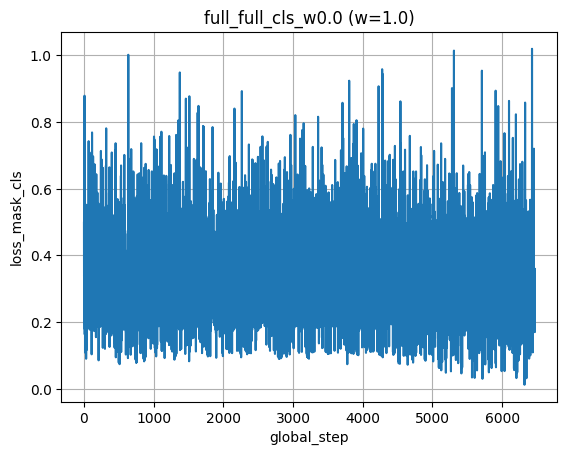

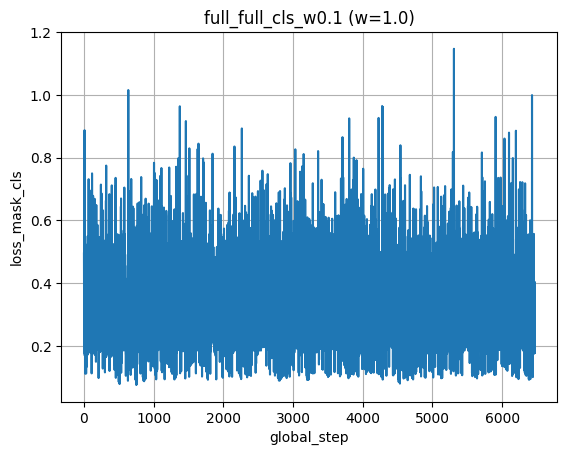

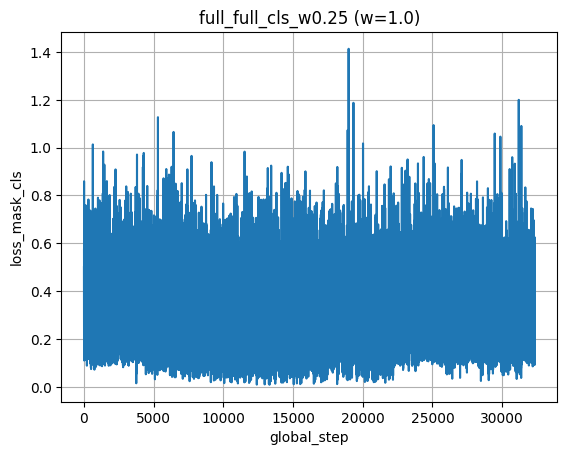

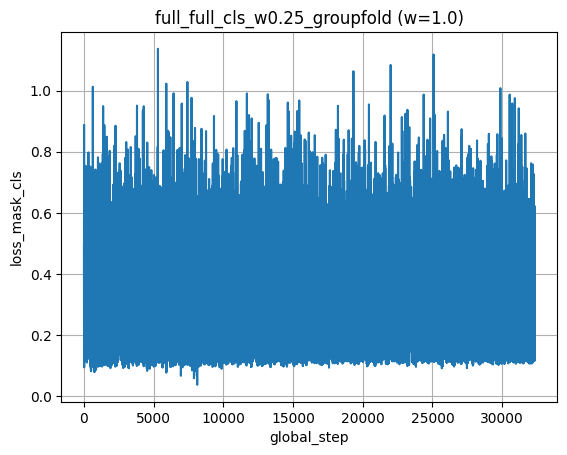

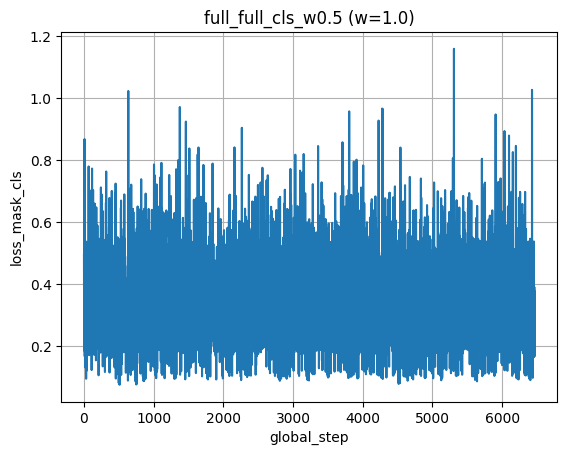

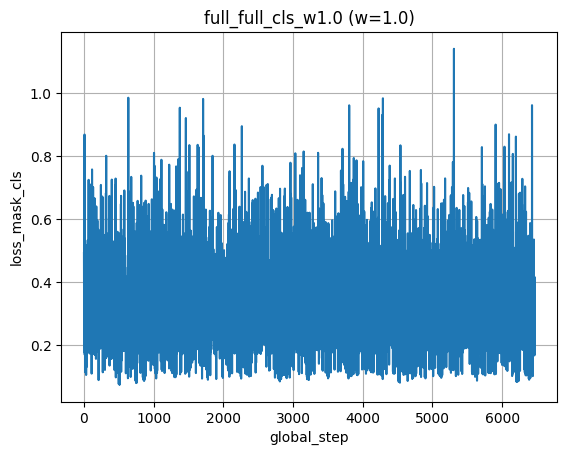

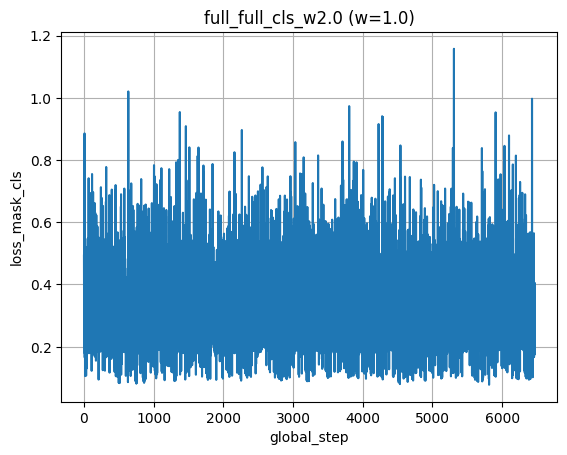

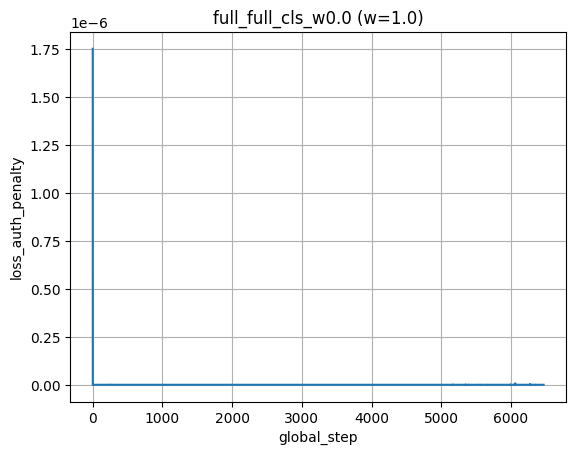

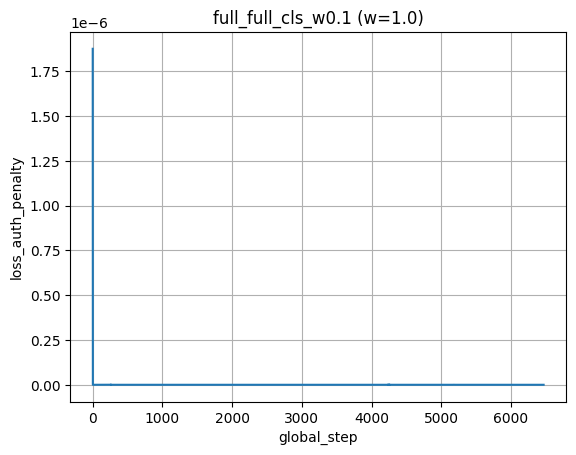

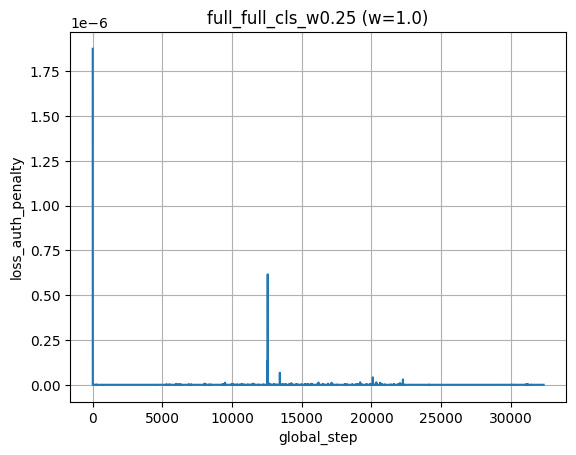

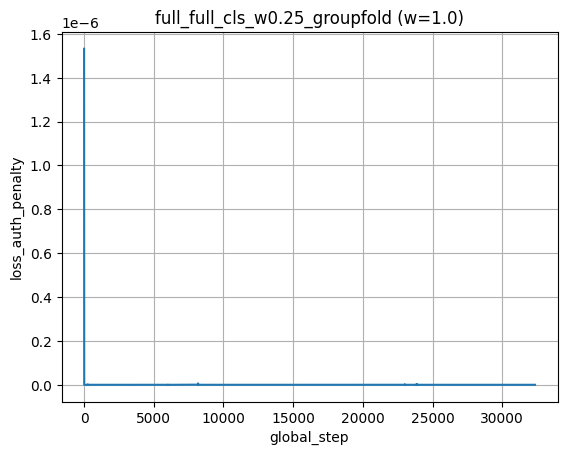

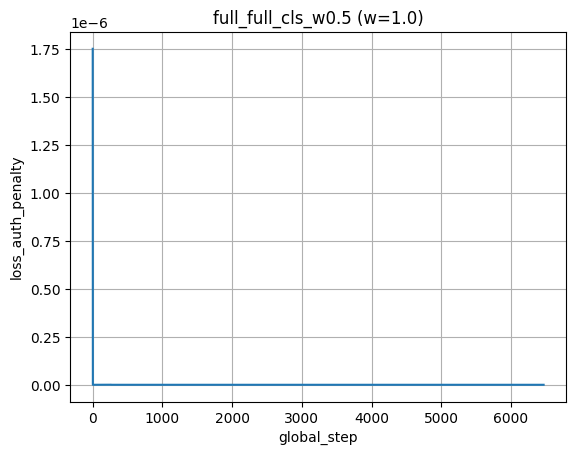

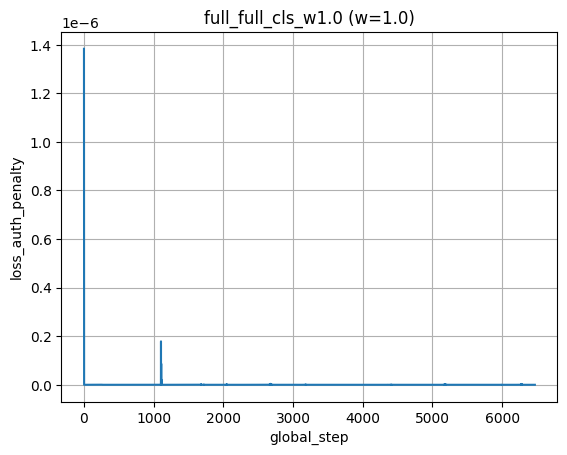

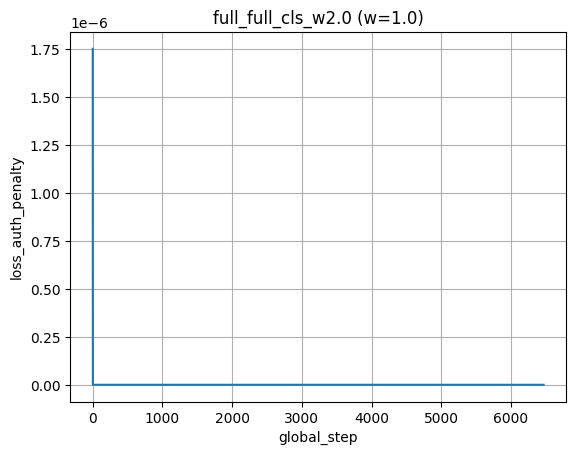

,tag,epoch,global_step,img_label,masks_shape,masks_sum,per_image,mask_logits,class_logits,img_logits,...,pos,total,pos_frac,thr,temp,authentic_frac,per_image_penalty_mean,loss_auth_penalty,run_name,w_mask_cls
0,loss_cls_targets,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,60.0,0.133333,NaN,NaN,NaN,NaN,NaN,full_full_cls_w0.0,1.0
1,loss_auth_penalty_stats,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.5,0.1,0.25,4.810166e-06,1.750315e-06,full_full_cls_w0.0,1.0
2,loss_cls_targets,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,60.0,0.033333,NaN,NaN,NaN,NaN,NaN,full_full_cls_w0.0,1.0
3,loss_auth_penalty_stats,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.5,0.1,0.75,1.884978e-14,6.254478e-14,full_full_cls_w0.0,1.0
4,loss_cls_targets,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,60.0,0.083333,NaN,NaN,NaN,NaN,NaN,full_full_cls_w0.0,1.0


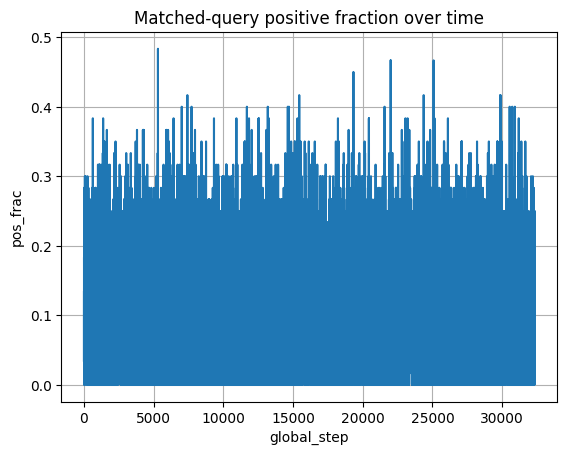

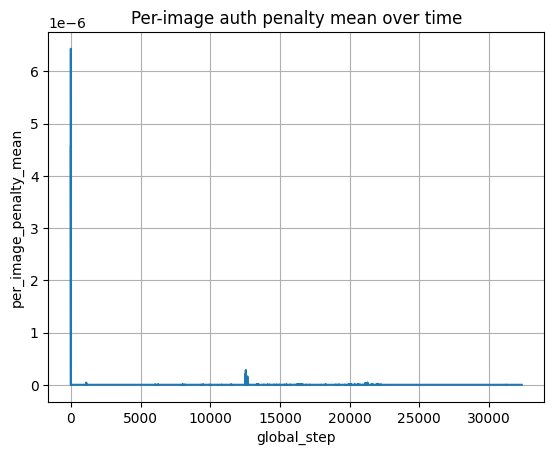

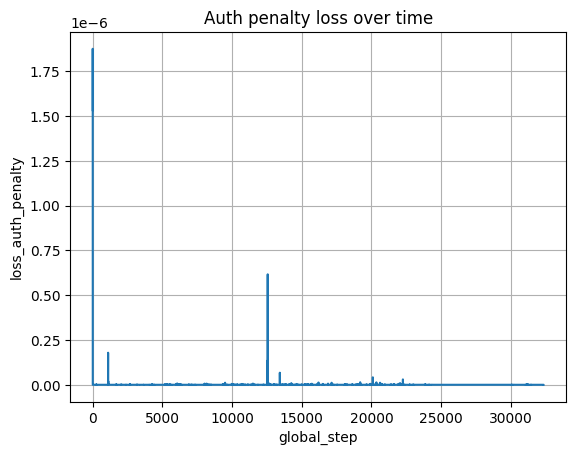

,run_name,w_mask_cls,cls_max_mean_last,mask_max_mean_last,img_forged_mean_last,cls_collapsed@~0.125,mask_saturated@~1.0
0,full_full_cls_w0.0,1.0,0.118643,0.926518,0.683643,False,False
1,full_full_cls_w0.1,1.0,0.099067,0.999999,0.528509,False,True
2,full_full_cls_w0.25,1.0,0.152679,0.999965,0.506893,False,True
3,full_full_cls_w0.25_groupfold,1.0,0.146112,0.999999,0.417405,False,True
4,full_full_cls_w0.5,1.0,0.112971,1.000000,0.557180,False,True
5,full_full_cls_w1.0,1.0,0.111575,0.999980,0.541513,False,True
6,full_full_cls_w2.0,1.0,0.113916,0.999225,0.725120,False,True


In [6]:
# notebooks/analyze_cls_weight_sweep.ipynb (run from repo root)


# Logs are written by ClsCollapseLogger to:
# experiments/cls_collapse/<run_name>/{meta.json, optimizer.json, step_losses.csv, epoch_summary.csv, debug.jsonl}
# :contentReference[oaicite:0]{index=0}

BASE = Path("../experiments/cls_collapse")

def _safe_read_json(p: Path):
    if not p.exists():
        return None
    return json.loads(p.read_text())

def _safe_read_csv(p: Path):
    if not p.exists():
        return None
    return pd.read_csv(p)

def _safe_read_jsonl(p: Path):
    if not p.exists():
        return None
    rows = []
    with p.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return pd.DataFrame(rows) if rows else pd.DataFrame()

def load_run(run_dir: Path):
    meta = _safe_read_json(run_dir / "meta.json") or {}
    opt  = _safe_read_json(run_dir / "optimizer.json") or {}
    steps = _safe_read_csv(run_dir / "step_losses.csv")
    epochs = _safe_read_csv(run_dir / "epoch_summary.csv")
    dbg = _safe_read_jsonl(run_dir / "debug.jsonl")

    # Prefer weight from logged CSV snapshot (most robust)
    w = None
    if steps is not None and "w_mask_cls" in steps.columns and len(steps):
        w = float(pd.to_numeric(steps["w_mask_cls"], errors="coerce").dropna().iloc[-1])
    elif epochs is not None and "w_mask_cls" in epochs.columns and len(epochs):
        w = float(pd.to_numeric(epochs["w_mask_cls"], errors="coerce").dropna().iloc[-1])

    out = {
        "run_dir": run_dir,
        "run_name": run_dir.name,
        "w_mask_cls": w,
        "meta": meta,
        "optimizer": opt,
        "step_losses": steps,
        "epoch_summary": epochs,
        "debug": dbg,
    }
    return out

def load_sweep_runs(base=BASE, name_prefix="full_full_cls_w"):
    run_dirs = sorted([p for p in base.glob(f"{name_prefix}*") if p.is_dir()])
    runs = [load_run(rd) for rd in run_dirs]
    # Keep only runs that look like our sweep (have at least epoch_summary or step_losses)
    runs = [r for r in runs if (r["epoch_summary"] is not None or r["step_losses"] is not None)]
    return runs

runs = load_sweep_runs()
print("Found runs:", len(runs))
for r in runs:
    print(r["run_name"], "w_mask_cls=", r["w_mask_cls"])

# ----------------------------
# Build a compact sweep table
# ----------------------------
rows = []
for r in runs:
    epochs = r["epoch_summary"]
    steps = r["step_losses"]

    last_epoch = None
    if epochs is not None and len(epochs):
        last_epoch = epochs.sort_values("epoch").iloc[-1].to_dict()

    last_step = None
    if steps is not None and len(steps):
        last_step = steps.sort_values("global_step").iloc[-1].to_dict()

    rows.append({
        "run_name": r["run_name"],
        "run_dir": str(r["run_dir"]),
        "w_mask_cls": r["w_mask_cls"],
        "epochs_logged": int(epochs["epoch"].max()) if epochs is not None and len(epochs) else np.nan,
        "steps_logged": int(steps["global_step"].max()) + 1 if steps is not None and len(steps) else np.nan,

        # epoch-end collapse detectors
        "cls_max_mean_last": (last_epoch or {}).get("cls_max_mean", np.nan),
        "cls_max_p95_last":  (last_epoch or {}).get("cls_max_p95", np.nan),
        "mask_max_mean_last":(last_epoch or {}).get("mask_max_mean", np.nan),
        "img_forged_mean_last": (last_epoch or {}).get("img_forged_mean", np.nan),

        # loss snapshot
        "loss_total_last": (last_step or {}).get("loss_total", np.nan),
        "loss_mask_cls_last": (last_step or {}).get("loss_mask_cls", np.nan),
        "loss_auth_penalty_last": (last_step or {}).get("loss_auth_penalty", np.nan),
    })

sweep_df = pd.DataFrame(rows).sort_values("w_mask_cls", na_position="last")
display(sweep_df)

# ----------------------------
# Plots: collapse vs w
# ----------------------------
def plot_vs_w(df, x="w_mask_cls", ys=()):
    dfp = df.dropna(subset=[x]).sort_values(x)
    for y in ys:
        plt.figure()
        plt.plot(dfp[x].values, dfp[y].values, marker="o")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f"{y} vs {x}")
        plt.grid(True)
        plt.show()

plot_vs_w(
    sweep_df,
    ys=["cls_max_mean_last", "cls_max_p95_last", "mask_max_mean_last", "img_forged_mean_last", "loss_total_last"]
)

# ----------------------------
# Per-run learning curves
# ----------------------------
def plot_run_curves(runs, metric="loss_total"):
    for r in runs:
        steps = r["step_losses"]
        if steps is None or metric not in steps.columns:
            continue
        steps = steps.sort_values("global_step")
        plt.figure()
        plt.plot(steps["global_step"], steps[metric])
        plt.xlabel("global_step")
        plt.ylabel(metric)
        plt.title(f"{r['run_name']} (w={r['w_mask_cls']})")
        plt.grid(True)
        plt.show()

plot_run_curves(runs, metric="loss_total")
plot_run_curves(runs, metric="loss_mask_cls")
plot_run_curves(runs, metric="loss_auth_penalty")

# ----------------------------
# Debug JSONL: auth penalty + cls target density over time
# ----------------------------
def extract_debug_timeseries(runs):
    all_rows = []
    for r in runs:
        dbg = r["debug"]
        if dbg is None or dbg.empty:
            continue
        # keep only structured events we care about
        keep = dbg[dbg["tag"].isin(["loss_auth_penalty_stats", "loss_cls_targets"])].copy()
        if keep.empty:
            continue
        keep["run_name"] = r["run_name"]
        keep["w_mask_cls"] = r["w_mask_cls"]
        # normalize common x-axis
        if "global_step" not in keep.columns:
            keep["global_step"] = np.nan
        all_rows.append(keep)
    return pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()

dbg_df = extract_debug_timeseries(runs)
display(dbg_df.head() if not dbg_df.empty else dbg_df)

def plot_debug_series(dbg_df, tag, y, title=None):
    if dbg_df.empty:
        print("No debug events found.")
        return
    sub = dbg_df[dbg_df["tag"] == tag].copy()
    if sub.empty or y not in sub.columns:
        print(f"No rows for tag={tag} with field {y}")
        return
    sub = sub.dropna(subset=["w_mask_cls"]).sort_values(["w_mask_cls", "global_step"])

    for w, g in sub.groupby("w_mask_cls"):
        g = g.sort_values("global_step")
        plt.figure()
        plt.plot(g["global_step"].values, g[y].values)
        plt.xlabel("global_step")
        plt.ylabel(y)
        plt.title(title or f"{tag}:{y} (w={w})")
        plt.grid(True)
        plt.show()

plot_debug_series(dbg_df, tag="loss_cls_targets", y="pos_frac", title="Matched-query positive fraction over time")
plot_debug_series(dbg_df, tag="loss_auth_penalty_stats", y="per_image_penalty_mean", title="Per-image auth penalty mean over time")
plot_debug_series(dbg_df, tag="loss_auth_penalty_stats", y="loss_auth_penalty", title="Auth penalty loss over time")


# ----------------------------
# Quick "collapse flags" summary
# ----------------------------
flags = sweep_df.copy()
flags["cls_collapsed@~0.125"] = np.isfinite(flags["cls_max_mean_last"]) & (np.abs(flags["cls_max_mean_last"] - 0.125) < 1e-3)
flags["mask_saturated@~1.0"] = np.isfinite(flags["mask_max_mean_last"]) & (flags["mask_max_mean_last"] > 0.99)
display(flags[["run_name","w_mask_cls","cls_max_mean_last","mask_max_mean_last","img_forged_mean_last","cls_collapsed@~0.125","mask_saturated@~1.0"]]
        .sort_values("w_mask_cls", na_position="last"))
